In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

from modules.experiment_pipeline import (
    ExperimentConfig,
    run_experiment_pipeline,
    results_to_dataframe,
    get_model,
    get_best_model,
    get_confusion_matrix,
    get_predictions,
)

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../data/X_final.pkl', 'rb') as f:
    X = pickle.load(f)
with open('../data/labels.pkl', 'rb') as f:
    y = pickle.load(f)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

X shape: (39100, 50029)
y shape: (39100,)
Class distribution: [17903 21197]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 29325
Test size: 9775


In [ ]:
# Define Experiments (narrowed search)
experiments = [
    ExperimentConfig(
        name="LinearSVC",
        kernel="linear",
        param_space={
            "C": ("float_log", 5.0, 12.0),  
        },
        n_trials=10,
        cv_folds=5,
    ),

    ExperimentConfig(
        name="Poly_SVC",
        kernel="poly",
        param_space={
            "C": ("float_log", 0.01, 0.5),   
            "degree": ("int", 1, 3),         
            "coef0": ("float", 0.0, 4.0),   
        },
        n_trials=5,
        cv_folds=3,
    ),

    ExperimentConfig(
        name="RBF_SVC",
        kernel="rbf",
        param_space={
            "C": ("float_log", 0.8, 2.5),
            "gamma": ("float_log", 0.04, 0.12),
        },
        n_trials=2,
        cv_folds=3,
    )
]

In [ ]:
# Run Pipeline
results = run_experiment_pipeline(
    X_train, y_train,
    X_test, y_test,
    experiments=experiments,
    experiment_name="fake_news_svm",
    random_state=42,
    n_jobs=-1,
    save_models=True,
    class_names=["Fake", "Real"],
)

2025-12-07 12:40:45 - experiment_pipeline - INFO - ############################################################
2025-12-07 12:40:45 - experiment_pipeline - INFO - EXPERIMENT PIPELINE: fake_news_svm
2025-12-07 12:40:45 - experiment_pipeline - INFO - Total experiments: 1
2025-12-07 12:40:45 - experiment_pipeline - INFO - ############################################################
2025-12-07 12:40:45 - experiment_pipeline - INFO - ============================================================
2025-12-07 12:40:45 - experiment_pipeline - INFO - EXPERIMENT: Poly_SVC
2025-12-07 12:40:45 - experiment_pipeline - INFO - Kernel: poly | Trials: 5 | CV: 3-fold
2025-12-07 12:40:45 - experiment_pipeline - INFO - ============================================================
2025-12-07 12:40:45 - experiment_pipeline - INFO - Starting optimization: Poly_SVC (5 trials, 3-fold CV)
Best trial: 3. Best value: 1: 100%|██████████| 5/5 [11:43<00:00, 140.61s/it]       
2025-12-07 12:52:28 - experiment_pipeline - 

Metadata saved to /Users/otosamada/Documents/University Assignmnets/ML/DABN14_Project_1/notebooks/../model_metadata/experiments/fake_news_svm.json


In [ ]:
df_results = results_to_dataframe(results)
df_results

,model,kernel,test_accuracy,test_f1,cv_score,training_time_s,inference_time_ms,optimization_time_s,n_trials,C,degree,coef0,gamma
0,Poly_SVC,poly,1.000000,1.000000,1.000000,65.550348,1.819573,155.556251,3,0.222362,4.0,4.059067,NaN
1,RBF_SVC,rbf,0.999591,0.999623,0.999591,51.814690,1.306768,99.488353,2,2.327600,NaN,NaN,0.045334
2,LinearSVC,linear,0.998875,0.998962,0.998534,4.380028,0.000689,51.568678,10,6.962757,NaN,NaN,NaN


In [7]:
df_results.to_csv('../data/svm_experiment_results_run_2.csv', index=False)

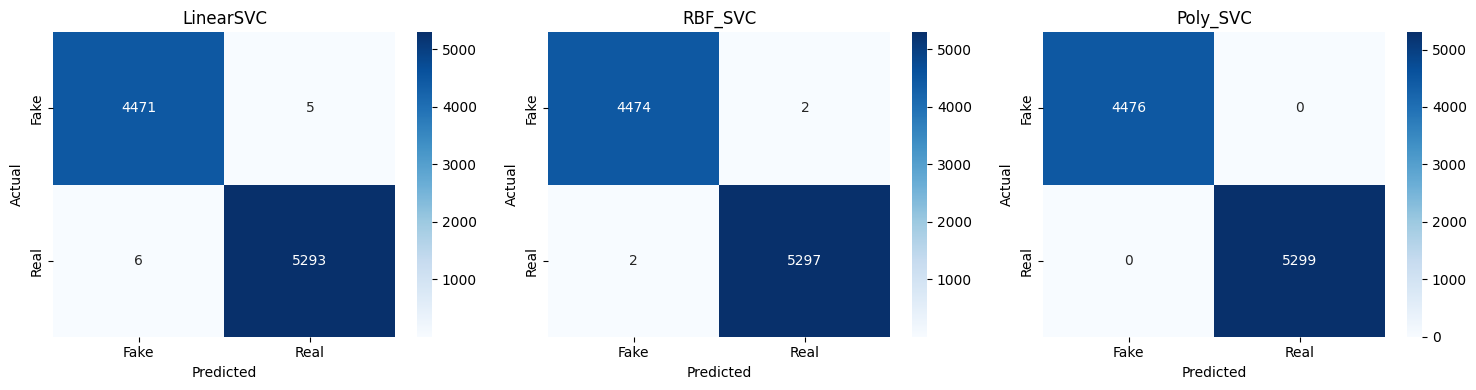

In [ ]:
# Confusion Matrices
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, name in zip(axes, ["LinearSVC", "RBF_SVC", "Poly_SVC"]):
    cm = get_confusion_matrix(results, name)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Fake', 'Real'],
        yticklabels=['Fake', 'Real'],
        ax=ax
    )
    ax.set_title(f"{name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()